# sequence prediction sandbox


In [1]:
import torch
from torch.utils.data import TensorDataset,DataLoader
from torch import nn

import logomaker
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
random.seed(7) #10

import utils as u

In [2]:
from itertools import product

In [3]:
seqs6 = [''.join(x) for x in product(['A','C','G','T'], repeat=6)]
print('Total 6mers:',len(seqs6))

seqs8 = [''.join(x) for x in product(['A','C','G','T'], repeat=8)]
print('Total 8mers:',len(seqs8))

Total 6mers: 4096
Total 8mers: 65536


In [4]:
score_dict = {
    'A':20,
    'C':17,
    'G':14,
    'T':11
}
def score_seqs(seqs):
    data = []
    for seq in seqs:
        score = np.mean([score_dict[base] for base in seq])
        data.append([seq,score])
        
    df = pd.DataFrame(data, columns=['seq','score'])
    return df
                  
def score_seqs_motif(seqs):
    data = []
    for seq in seqs:
        score = np.mean([score_dict[base] for base in seq])
        if 'TAT' in seq:
            score += 10
        if 'GCG' in seq:
            score -= 10
        data.append([seq,score])
        
    df = pd.DataFrame(data, columns=['seq','score'])
    return df
    

In [5]:
mer6 = score_seqs(seqs6)
mer6.head()

,seq,score
0,AAAAAA,20.0
1,AAAAAC,19.5
2,AAAAAG,19.0
3,AAAAAT,18.5
4,AAAACA,19.5


In [6]:
mer8 = score_seqs(seqs8)
mer8.head()

,seq,score
0,AAAAAAAA,20.000
1,AAAAAAAC,19.625
2,AAAAAAAG,19.250
3,AAAAAAAT,18.875
4,AAAAAACA,19.625


In [7]:
mer6_motif = score_seqs_motif(seqs6)
mer8_motif = score_seqs_motif(seqs8)


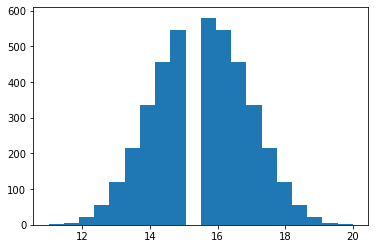

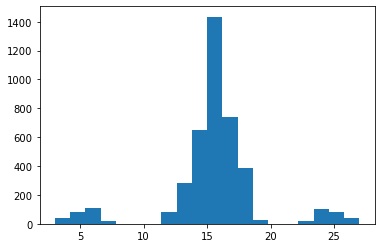

In [8]:
plt.hist(mer6['score'].values,bins=20)
plt.show()

plt.hist(mer6_motif['score'].values,bins=20)
plt.show()

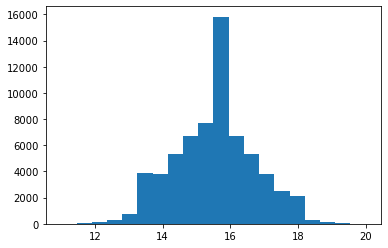

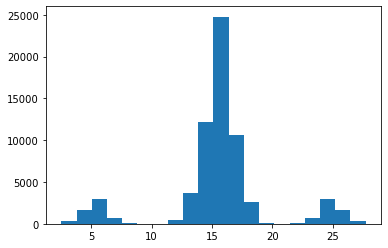

In [9]:
plt.hist(mer8['score'].values,bins=20)
plt.show()

plt.hist(mer8_motif['score'].values,bins=20)
plt.show()

In [20]:
def quick_split(df, split_frac=0.8, verbose=False):
    '''
    Given a df, randomly split between
    train and test. Not a formal train/test split, just a quick n dirty version.
    
    '''

    # train test split
    idxs = list(range(df.shape[0]))
    random.shuffle(idxs)

    split = int(len(idxs)*split_frac)
    train_idxs = idxs[:split]
    test_idxs = idxs[split:]
    
    # split df and convert to tensors
    train_df = df[df.index.isin(train_idxs)]
    test_df = df[df.index.isin(test_idxs)]
        
    return train_df, test_df

def build_dataloaders_single(df, seq_encoding="oh",target_col="score",batch_size=32):
    '''
    Given a df, encode the sequence for modeling, split into train and test 
    and put into pytorch loaders
    '''
    # if one-hot encoding, add oh column
    if seq_encoding == 'oh':
        df[seq_encoding] = df['seq'].apply(lambda x: u.one_hot_encode(x))
    elif seq_encoding == 'kmer':
        raise ValueError("Not implemented yet")
    else: 
        raise ValueError(f"Unknown seq encoding {seq_encoding}")
    
    # split
    train_df, test_df = quick_split(df)
    
    # make train test tensors and load into DataLoaders
    x_train = torch.tensor(list(train_df[seq_encoding].values))
    y_train = torch.tensor(list(train_df[target_col].values)).unsqueeze(1)
    x_test  = torch.tensor(list(test_df[seq_encoding].values))
    y_test  = torch.tensor(list(test_df[target_col].values)).unsqueeze(1)
    
    train_ds = TensorDataset(x_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    test_ds = TensorDataset(x_test, y_test)
    test_dl = DataLoader(test_ds, batch_size=batch_size * 2)
    
    return train_dl, test_dl, train_df, test_df

In [21]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    loss = loss_func(model(xb.float()), yb.float())

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    #print("lb returning:",loss.item(), len(xb))
    return loss.item(), len(xb)


def fit(epochs, model, loss_func, opt, train_dl, test_dl):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    test_losses = []
    
    # loops through epochs
    for epoch in range(epochs):
        #print("TRAIN")
        model.train()
        ts = []
        ns = []
        # collect train loss; provide opt so backpropo happens
        for xb, yb in train_dl:
            t, n = loss_batch(model, loss_func, xb, yb, opt=opt)
            ts.append(t)
            ns.append(n)
        train_loss = np.sum(np.multiply(ts, ns)) / np.sum(ns)
        train_losses.append(train_loss)
        
        #print("EVAL")
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                # loop through test batches
                # returns loss calc for test set batch size
                # unzips into two lists
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in test_dl]
                # Note: no opt provided, backprop won't happen
            )
        # Gets average MSE loss across all batches (may be of diff sizes, hence the multiply)
        #print("losses", losses)
        #print("nums", nums)
        test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, test_loss)
        test_losses.append(test_loss)

    return train_losses, test_losses

In [22]:
class DNA_Linear(nn.Module):
    def __init__(self, seq_len,h1_size):
        super().__init__()
        self.seq_len = seq_len
        
        self.lin = nn.Sequential(
            nn.Linear(4*seq_len, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, 1),
            nn.ReLU(inplace=True)
        )

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        return self.lin(xb)
    

    
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=32,
                 kernel_size=3):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            nn.Conv1d(4, num_filters, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(num_filters*(seq_len-kernel_size+1), 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 1),
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #print(xb.shape)
        xb = self.conv_net(xb)
        return xb

In [23]:
def run_model(train_dl,test_dl, model, lr=0.01, epochs=20):
    '''
    Given data and a model type, run dataloaders with MSE loss and SGD opt
    '''
    # define loss func and optimizer
    loss_func = torch.nn.MSELoss() 
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) 
    
    # run the training loop
    train_losses, test_losses = fit(epochs, model, loss_func, optimizer, train_dl, test_dl)
    
    #return model, train_losses, test_losses
    return train_losses, test_losses

In [24]:
def quick_loss_plot(data_label):
    '''Plot loss by epoch'''
    for data, label in data_label:
        plt.plot(data, label=label)
    plt.legend()
    plt.ylabel("MSE loss")
    plt.xlabel("Epoch")
    plt.show()
    
def quick_seq_pred(model, seqs):
    '''Given some sequences, get the model's predictions '''
    for dna in seqs:
        s = torch.tensor(u.one_hot_encode(dna))
        pred = model(s.float())
        print(dna, pred.item())

# Single Task Regression


In [25]:
mer6_train_dl, mer6_test_dl, mer6_train_df, mer6_test_df = build_dataloaders_single(mer6)

In [26]:
mer6_test_df

,seq,score,oh
3,AAAAAT,18.5,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ..."
5,AAAACC,19.0,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ..."
10,AAAAGG,18.0,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ..."
16,AAACAA,19.5,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ..."
21,AAACCC,18.5,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ..."
...,...,...,...
4071,TTTGCT,12.5,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
4074,TTTGGG,12.5,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
4079,TTTGTT,11.5,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
4083,TTTTAT,12.5,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."


0 0.0016842863420251666
1 0.0014142891920239824
2 0.0013620714662687444
3 0.0012762961988678067
4 0.0012550204435772285
5 0.0012307446654431704
6 0.0011736565303602598
7 0.0011223379039864351
8 0.0010600006128320607
9 0.001062574164328597
10 0.0009937117966573412
11 0.00117094489041625
12 0.000948637761970664
13 0.0009061271898312176
14 0.0008645643048533579
15 0.0008549962820280797
16 0.0008245972848338325
17 0.000820248547896016
18 0.0008656529738090751
19 0.0007429457147514856


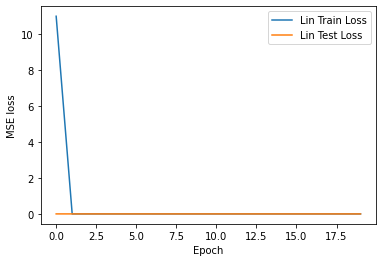

In [27]:
seq_len = len(mer6_train_df['seq'].values[0])
hidden_layer_size = 24

mer6_model_lin = DNA_Linear(seq_len, hidden_layer_size)

mer6_train_losses, mer6_test_losses = run_model(mer6_train_dl, mer6_test_dl, mer6_model_lin)

# to plot loss
mer6_lin_data_label = list(zip([mer6_train_losses,mer6_test_losses], ['Lin Train Loss','Lin Test Loss']))
quick_loss_plot(mer6_lin_data_label)

In [28]:
def quick_test(model):
    seqs1 = ['AAAAAA', 'CCCCCC','GGGGGG','TTTTTT']
    seqs2 = ['AACCAA','CCGGGG','GGGTAA', 'TTTCGT','TGTAAT']
    seqsTAT = ['TATAAA','CCTATC','GTATGG','TTTATT']
    seqsGCG = ['AAGCGA','CGCGCC','GGGCGG','TTGCGT']
    TATGCG =  ['TATGCG','GCGTAT']

    for seqs in [seqs1, seqs2, seqsTAT, seqsGCG, TATGCG]:
        quick_seq_pred(model, seqs)
        print()

In [29]:
quick_test(mer6_model_lin)

AAAAAA 20.005207061767578
CCCCCC 17.007963180541992
GGGGGG 13.978490829467773
TTTTTT 11.038773536682129

AACCAA 18.965042114257812
CCGGGG 15.01977252960205
GGGTAA 15.571381568908691
TTTCGT 12.50156307220459
TGTAAT 14.518507957458496

TATAAA 16.97784996032715
CCTATC 15.493341445922852
GTATGG 13.980352401733398
TTTATT 12.432066917419434

AAGCGA 17.50442886352539
CGCGCC 16.001407623291016
GGGCGG 14.488242149353027
TTGCGT 12.978005409240723

TATGCG 14.518893241882324
GCGTAT 14.509551048278809



# Single task Regression with Motifs
### Linear Model

In [31]:
mer6motif_train_dl, mer6motif_test_dl, mer6motif_train_df, mer6motif_test_df = build_dataloaders_single(mer6_motif)

0 12.445640545356564
1 10.148458090061094
2 9.974036212083771
3 9.705261872454388
4 12.489409735144639
5 9.618157298390459
6 9.56795697793728
7 9.407006935957002
8 9.366499689148693
9 8.493241347336188
10 9.783364128484958
11 10.088309771840166
12 7.819811876808725
13 7.430391002282864
14 7.3796169490349
15 7.187675836609631
16 7.042873773342226
17 6.992294585995558
18 6.652606045327535
19 7.7982245468511815


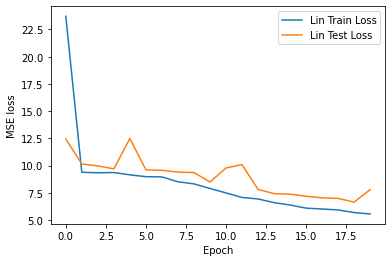

In [32]:
seq_len = len(mer6motif_train_df['seq'].values[0])
hidden_layer_size = 24

mer6motif_model_lin = DNA_Linear(seq_len, hidden_layer_size)

mer6motif_train_losses_lin, mer6motif_test_losses_lin = run_model(mer6motif_train_dl, mer6motif_test_dl, mer6motif_model_lin,lr=0.01)

# to plot loss
mer6motif_lin_data_label = list(zip([mer6motif_train_losses_lin,mer6motif_test_losses_lin], ['Lin Train Loss','Lin Test Loss']))
quick_loss_plot(mer6motif_lin_data_label)

In [33]:
quick_test(mer6motif_model_lin)

AAAAAA 18.460844039916992
CCCCCC 17.257898330688477
GGGGGG 10.262024879455566
TTTTTT 13.122960090637207

AACCAA 18.200927734375
CCGGGG 12.179768562316895
GGGTAA 15.466217994689941
TTTCGT 10.179841041564941
TGTAAT 16.524080276489258

TATAAA 21.806259155273438
CCTATC 21.215023040771484
GTATGG 16.655704498291016
TTTATT 17.643274307250977

AAGCGA 10.755572319030762
CGCGCC 8.830829620361328
GGGCGG 7.319896221160889
TTGCGT 6.820153713226318

TATGCG 14.006457328796387
GCGTAT 13.425713539123535



In [39]:
mer6_motif[mer6_motif['seq']=='AAGCGA']

,seq,score,oh
152,AAGCGA,7.5,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."


### CNN Model

0 18.035495113744968
1 8.502891791739115
2 5.38499172257214
3 6.369453976793987
4 3.2178969668179023
5 2.357239850555978
6 3.214841189035555
7 1.247276236952805
8 0.8030129646382681
9 1.2380779080274629
10 1.1989054976440057
11 0.7122622527727267
12 0.3347574261630454
13 0.3050850869315426
14 0.2972756494290945
15 0.37599703080770447
16 0.33292775633858473
17 0.4196810550079113
18 0.348264743860175
19 0.2585268664196497


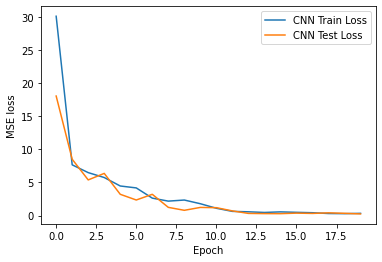

In [42]:
seq_len = len(mer6motif_train_df['seq'].values[0])

mer6motif_model_cnn = DNA_CNN(seq_len, num_filters=32,kernel_size=3)

mer6motif_train_losses_cnn, mer6motif_test_losses_cnn = run_model(mer6motif_train_dl, mer6motif_test_dl, mer6motif_model_cnn, lr=0.01)

# to plot loss
mer6motif_cnn_data_label = list(zip([mer6motif_train_losses_cnn,mer6motif_test_losses_cnn], ['CNN Train Loss','CNN Test Loss']))
quick_loss_plot(mer6motif_cnn_data_label)

In [43]:
quick_test(mer6motif_model_cnn)

AAAAAA 20.144338607788086
CCCCCC 16.97021484375
GGGGGG 14.012731552124023
TTTTTT 11.073119163513184

AACCAA 19.110454559326172
CCGGGG 15.022076606750488
GGGTAA 15.730791091918945
TTTCGT 12.645739555358887
TGTAAT 14.53404426574707

TATAAA 26.80276107788086
CCTATC 25.58512306213379
GTATGG 24.0166072845459
TTTATT 22.702518463134766

AAGCGA 7.397052764892578
CGCGCC 6.40894889831543
GGGCGG 4.3624725341796875
TTGCGT 3.385941505432129

TATGCG 14.51004409790039
GCGTAT 14.123952865600586



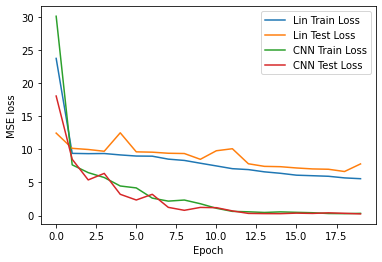

In [44]:
comb_data_label = list(zip([mer6motif_train_losses_lin,mer6motif_test_losses_lin,mer6motif_train_losses_cnn,mer6motif_test_losses_cnn], 
                          ['Lin Train Loss','Lin Test Loss','CNN Train Loss','CNN Test Loss']))

quick_loss_plot(comb_data_label)

# Try with 8 mers

# Single Task Regression


In [45]:
mer8_train_dl, mer8_test_dl, mer8_train_df, mer8_test_df = build_dataloaders_single(mer8)

In [46]:
mer8_test_df

,seq,score,oh
0,AAAAAAAA,20.000,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ..."
9,AAAAAAGC,18.875,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ..."
16,AAAAACAA,19.625,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ..."
22,AAAAACCG,18.500,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ..."
27,AAAAACGT,17.750,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ..."
...,...,...,...
65524,TTTTTTCA,12.875,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
65525,TTTTTTCC,12.500,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
65527,TTTTTTCT,11.750,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
65532,TTTTTTTA,12.125,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."


0 0.0007494764456790888
1 0.0004643387689931147
2 0.000341437688452039
3 0.00024079751724636323
4 0.0002134383050046337
5 0.0001494433932942229
6 0.00011453648264522926
7 9.783447075927282e-05
8 7.603666201261183e-05
9 6.598798503749435e-05
10 5.4115733050933695e-05
11 4.6613923368423744e-05
12 4.413211119383887e-05
13 3.481460071739744e-05
14 3.060928139004791e-05
15 2.7838212733133552e-05
16 2.89384049477354e-05
17 2.248788707146958e-05
18 3.794474504557107e-05
19 1.8724835876295133e-05


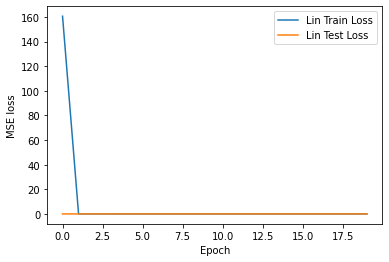

In [47]:
seq_len = len(mer8_train_df['seq'].values[0])
hidden_layer_size = 24

mer8_model_lin = DNA_Linear(seq_len, hidden_layer_size)

mer8_train_losses, mer8_test_losses = run_model(mer8_train_dl, mer8_test_dl, mer8_model_lin)

# to plot loss
mer8_lin_data_label = list(zip([mer8_train_losses,mer8_test_losses], ['Lin Train Loss','Lin Test Loss']))
quick_loss_plot(mer8_lin_data_label)

In [50]:
def quick_test8(model):
    seqs1 = ['AAAAAAAA', 'CCCCCCCC','GGGGGGGG','TTTTTTTT']
    seqs2 = ['AACCAACA','CCGGCGCG','GGGTAAGG', 'TTTCGTTT','TGTAATAC']
    seqsTAT = ['TATAAAAA','CCTATCCC','GTATGGGG','TTTATTTT']
    seqsGCG = ['AAGCGAAA','CGCGCCCC','GGGCGGGG','TTGCGTTT']
    TATGCG =  ['ATATGCGA','TGCGTATT']

    for seqs in [seqs1, seqs2, seqsTAT, seqsGCG, TATGCG]:
        quick_seq_pred(model, seqs)
        print()

In [51]:
quick_test8(mer8_model_lin)

AAAAAAAA 19.99751853942871
CCCCCCCC 17.00164222717285
GGGGGGGG 13.996614456176758
TTTTTTTT 11.000947952270508

AACCAACA 18.877992630004883
CCGGCGCG 15.519035339355469
GGGTAAGG 15.121597290039062
TTTCGTTT 12.12773323059082
TGTAATAC 15.503667831420898

TATAAAAA 17.747453689575195
CCTATCCC 15.877765655517578
GTATGGGG 13.998186111450195
TTTATTTT 12.126176834106445

AAGCGAAA 18.127744674682617
CGCGCCCC 16.25092124938965
GGGCGGGG 14.371723175048828
TTGCGTTT 12.502634048461914

ATATGCGA 15.873394012451172
TGCGTATT 13.623113632202148



# Single task Regression with Motifs
### Linear Model

In [52]:
mer8motif_train_dl, mer8motif_test_dl, mer8motif_train_df, mer8motif_test_df = build_dataloaders_single(mer8_motif)

0 10.239711933467749
1 8.658210508482172
2 8.92930915612508
3 5.762375424466265
4 5.693408600833672
5 3.711631412727279
6 3.3758865173975434
7 4.793131218038028
8 3.35278032565939
9 2.6072811299720695
10 2.5729143453655645
11 2.0140831696757973
12 2.167761345407313
13 3.9959377961657854
14 2.8089703832561734
15 6.06584278184683
16 6.235885328078074
17 5.571834397745234
18 2.146355569744605
19 2.258534303917767


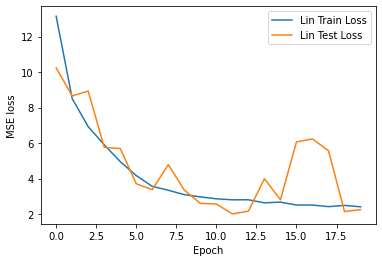

In [53]:
seq_len = len(mer8motif_train_df['seq'].values[0])
hidden_layer_size = 24

mer8motif_model_lin = DNA_Linear(seq_len, hidden_layer_size)

mer8motif_train_losses_lin, mer8motif_test_losses_lin = run_model(mer8motif_train_dl, mer8motif_test_dl, mer8motif_model_lin,lr=0.01)

# to plot loss
mer8motif_lin_data_label = list(zip([mer8motif_train_losses_lin,mer8motif_test_losses_lin], ['Lin Train Loss','Lin Test Loss']))
quick_loss_plot(mer8motif_lin_data_label)

In [55]:
quick_test8(mer8motif_model_lin)

AAAAAAAA 18.718584060668945
CCCCCCCC 18.062192916870117
GGGGGGGG 13.241281509399414
TTTTTTTT 12.696273803710938

AACCAACA 18.174968719482422
CCGGCGCG 0.0
GGGTAAGG 16.016454696655273
TTTCGTTT 12.646052360534668
TGTAATAC 16.23917007446289

TATAAAAA 25.315380096435547
CCTATCCC 26.082530975341797
GTATGGGG 23.368114471435547
TTTATTTT 21.01308250427246

AAGCGAAA 9.171072006225586
CGCGCCCC 7.479372024536133
GGGCGGGG 5.409816741943359
TTGCGTTT 5.273737907409668

ATATGCGA 15.652107238769531
TGCGTATT 13.512492179870605



In [63]:
mer8_motif[mer8_motif['seq']=='TTGCGTTT']

,seq,score,oh
63935,TTGCGTTT,2.5,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."


### CNN Model

0 0.5729735598973031
1 0.5812796416135688
2 0.4742585268300191
3 0.22586351851450986
4 0.13296329016579264
5 0.06992682580076451
6 0.031232885622325915
7 0.04156870139733771
8 0.07120537727293642
9 0.022905687195341834
10 0.20629493078699482
11 0.042607267715462034
12 0.012315835294177029
13 0.017213326568499568
14 0.008780139450027601
15 0.00729504602609616
16 0.009216017746178988
17 0.09746672438845826
18 0.007048494123768768
19 0.011571228805858941


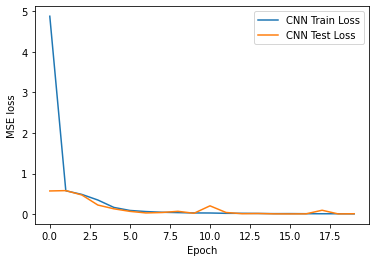

In [64]:
seq_len = len(mer8motif_train_df['seq'].values[0])

mer8motif_model_cnn = DNA_CNN(seq_len, num_filters=32,kernel_size=3)

mer8motif_train_losses_cnn, mer8motif_test_losses_cnn = run_model(mer8motif_train_dl, mer8motif_test_dl, mer8motif_model_cnn, lr=0.01)

# to plot loss
mer8motif_cnn_data_label = list(zip([mer8motif_train_losses_cnn,mer8motif_test_losses_cnn], ['CNN Train Loss','CNN Test Loss']))
quick_loss_plot(mer8motif_cnn_data_label)

In [65]:
quick_test8(mer8motif_model_cnn)

AAAAAAAA 19.870649337768555
CCCCCCCC 16.864274978637695
GGGGGGGG 13.936702728271484
TTTTTTTT 10.959371566772461

AACCAACA 18.764020919799805
CCGGCGCG 5.032990455627441
GGGTAAGG 15.051126480102539
TTTCGTTT 12.055513381958008
TGTAATAC 15.447744369506836

TATAAAAA 27.612253189086914
CCTATCCC 25.675199508666992
GTATGGGG 23.996009826660156
TTTATTTT 22.175161361694336

AAGCGAAA 8.046622276306152
CGCGCCCC 6.175624370574951
GGGCGGGG 4.326128005981445
TTGCGTTT 2.4491186141967773

ATATGCGA 14.840484619140625
TGCGTATT 13.896514892578125



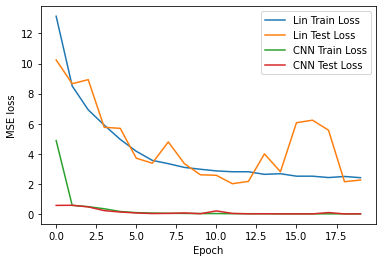

In [66]:
comb_data_label = list(zip([mer8motif_train_losses_lin,mer8motif_test_losses_lin,mer8motif_train_losses_cnn,mer8motif_test_losses_cnn], 
                          ['Lin Train Loss','Lin Test Loss','CNN Train Loss','CNN Test Loss']))

quick_loss_plot(comb_data_label)

# inspect

In [67]:
mer6motif_model_cnn

DNA_CNN(
  (conv_net): Sequential(
    (0): Conv1d(4, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=128, out_features=10, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [68]:
def get_conv_layers_from_model(model):
    '''
    Given a trained model, extract its convolutional layers
    '''
    model_children = list(model.children())
    
    # counter to keep count of the conv layers
    model_weights = [] # we will save the conv layer weights in this list
    conv_layers = [] # we will save the actual conv layers in this list
    bias_weights = []
    counter = 0 

    # append all the conv layers and their respective weights to the list
    for i in range(len(model_children)):
        # get model type of Conv1d
        if type(model_children[i]) == nn.Conv1d:
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
            bias_weights.append(model_children[i].bias)

        # also check sequential objects' children for conv1d
        elif type(model_children[i]) == nn.Sequential:
            for child in model_children[i]:
                if type(child) == nn.Conv1d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
                    bias_weights.append(child.bias)

    print(f"Total convolutional layers: {counter}")
    return conv_layers, model_weights, bias_weights

In [70]:
conv_layers, model_weights, bias_weights = get_conv_layers_from_model(mer6motif_model_cnn)

Total convolutional layers: 1


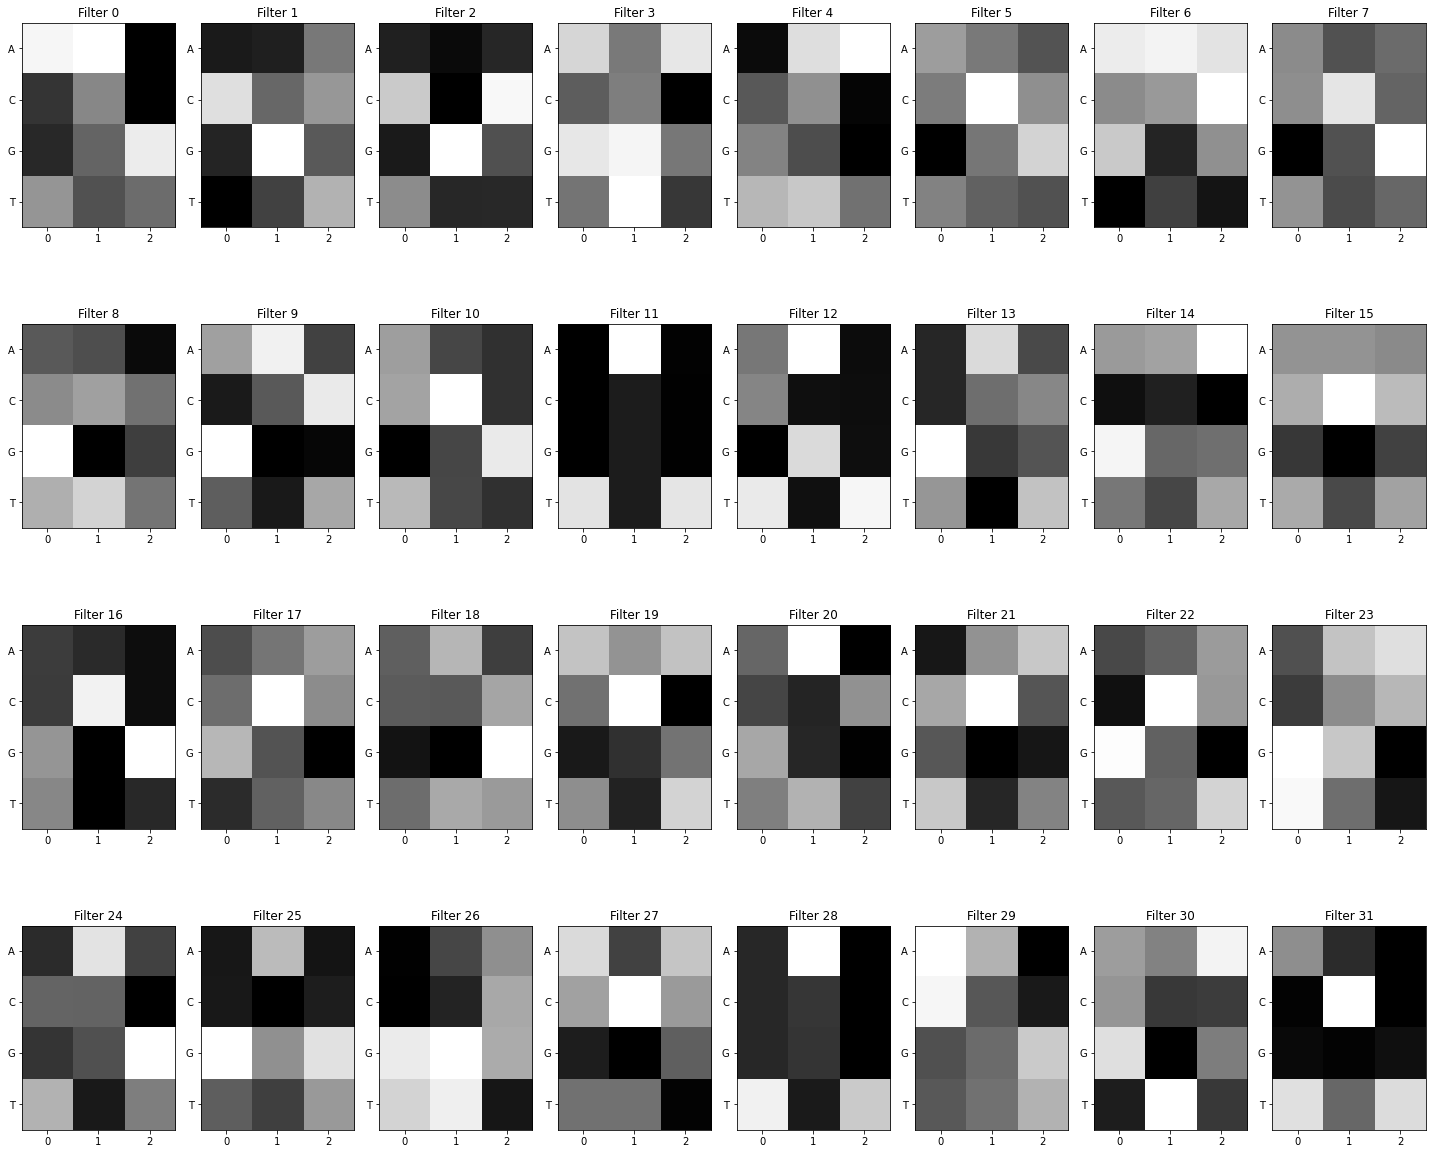

In [71]:
def view_filters(model_weights, num_cols=8):
    num_filt = model_weights[0].shape[0]
    num_rows = int(np.ceil(num_filt/num_cols))
    
    # visualize the first conv layer filters
    plt.figure(figsize=(20, 17))

    for i, filter in enumerate(model_weights[0]):
        ax = plt.subplot(num_rows, num_cols, i+1)
        ax.imshow(filter.detach(), cmap='gray')
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(['A', 'C', 'G','T'])
        ax.set_xticks(np.arange(3))
        ax.set_title(f"Filter {i}")

    plt.tight_layout()
    plt.show()
    
view_filters(model_weights)

In [72]:
def get_conv_output_for_seq(seq, conv_layer):
    '''
    Given an input sequeunce, get the output tensor containing the filter activations
    '''
    print(f"Running seq {seq}")
    # format seq for input to conv layer (OHE, reshape)
    seq = torch.tensor(u.one_hot_encode(seq)).view(-1,len(seq),4).permute(0,2,1)
    
    # run through conv layer
    with torch.no_grad(): # don't want as part of gradient graph?
        res = conv_layer(seq.float())
        return res[0]
    

def get_filter_activations(seqs, conv_layer):
    '''
    Given a set of input sequences and a trained convolutional layer, 
    determine the subsequences for which each filter in the conv layer 
    activate most strongly. 
    
    1.) Run inputs through conv layer. 
    2.) Loop through filter activations of the resulting tensor, saving the
            position where filter activations were >0. 
    3.) Compile a count matrix for each filter by accumulating subsequences which
            activate the filter
    '''
    # initialize dict of pwms for each filter in the conv layer
    num_filters = conv_layer.out_channels
    filt_width = conv_layer.kernel_size[0]
    filter_pwms = dict((i,torch.zeros(4,filt_width)) for i in range(num_filters))
    
    # loop through a set of sequences and collect subseqs where each filter activated
    for seq in seqs:
        res = get_conv_output_for_seq(seq, conv_layer)
        # for each filter and it's activation vector
        for filt_id,act_vec in enumerate(res):
            activated_positions = [x.item() for x in torch.where(act_vec>0)[0]]
            
            # get subsequences that caused filter to activate
            for pos in activated_positions:
                subseq = seq[pos:pos+filt_width]
                subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).view(-1,filt_width,4).permute(0,2,1).squeeze(0)
                
                # add this subseq to the pwm count for this filter
                filter_pwms[filt_id] += subseq_tensor
            
            
            
    return filter_pwms

In [73]:
train_seqs = list(mer6motif_train_df['seq'])
filter_activations = get_filter_activations(train_seqs, conv_layers[0])

Running seq AAAAAA
Running seq AAAAAG
Running seq AAAACC
Running seq AAAACG
Running seq AAAACT
Running seq AAAAGA
Running seq AAAAGC
Running seq AAAAGG
Running seq AAAATA
Running seq AAAATC
Running seq AAAATG
Running seq AAAATT
Running seq AAACAA
Running seq AAACAC
Running seq AAACAG
Running seq AAACAT
Running seq AAACCA
Running seq AAACCC
Running seq AAACCG
Running seq AAACCT
Running seq AAACGA
Running seq AAACGG
Running seq AAACTA
Running seq AAACTC
Running seq AAACTG
Running seq AAACTT
Running seq AAAGAA
Running seq AAAGAC
Running seq AAAGAG
Running seq AAAGAT
Running seq AAAGCA
Running seq AAAGCC
Running seq AAAGCT
Running seq AAAGGA
Running seq AAAGGC
Running seq AAAGGG
Running seq AAAGGT
Running seq AAAGTA
Running seq AAAGTC
Running seq AAAGTG
Running seq AAAGTT
Running seq AAATAA
Running seq AAATAG
Running seq AAATCA
Running seq AAATCC
Running seq AAATCG
Running seq AAATCT
Running seq AAATGA
Running seq AAATGG
Running seq AAATGT
Running seq AAATTA
Running seq AAATTC
Running seq 

Running seq AGCAAG
Running seq AGCAAT
Running seq AGCACC
Running seq AGCACG
Running seq AGCACT
Running seq AGCAGA
Running seq AGCAGC
Running seq AGCATA
Running seq AGCATC
Running seq AGCATG
Running seq AGCATT
Running seq AGCCAA
Running seq AGCCAC
Running seq AGCCAG
Running seq AGCCCA
Running seq AGCCCC
Running seq AGCCCG
Running seq AGCCGA
Running seq AGCCGC
Running seq AGCCGG
Running seq AGCCGT
Running seq AGCCTA
Running seq AGCCTG
Running seq AGCCTT
Running seq AGCGAC
Running seq AGCGAG
Running seq AGCGAT
Running seq AGCGCA
Running seq AGCGCC
Running seq AGCGCG
Running seq AGCGCT
Running seq AGCGGA
Running seq AGCGGC
Running seq AGCGGT
Running seq AGCGTA
Running seq AGCGTC
Running seq AGCGTT
Running seq AGCTAA
Running seq AGCTAG
Running seq AGCTAT
Running seq AGCTCC
Running seq AGCTCT
Running seq AGCTGG
Running seq AGCTGT
Running seq AGCTTA
Running seq AGGAAA
Running seq AGGAAG
Running seq AGGAAT
Running seq AGGACA
Running seq AGGACC
Running seq AGGACG
Running seq AGGACT
Running seq 

Running seq CACTCT
Running seq CACTGA
Running seq CACTGC
Running seq CACTGG
Running seq CACTGT
Running seq CACTTA
Running seq CACTTC
Running seq CACTTG
Running seq CACTTT
Running seq CAGAAA
Running seq CAGACC
Running seq CAGACG
Running seq CAGACT
Running seq CAGAGA
Running seq CAGAGC
Running seq CAGAGG
Running seq CAGAGT
Running seq CAGATA
Running seq CAGATC
Running seq CAGATG
Running seq CAGATT
Running seq CAGCAA
Running seq CAGCAC
Running seq CAGCAT
Running seq CAGCCA
Running seq CAGCCC
Running seq CAGCCT
Running seq CAGCGA
Running seq CAGCGC
Running seq CAGCGT
Running seq CAGCTA
Running seq CAGCTC
Running seq CAGGAA
Running seq CAGGAT
Running seq CAGGCA
Running seq CAGGCC
Running seq CAGGCG
Running seq CAGGCT
Running seq CAGGGA
Running seq CAGGGG
Running seq CAGGTA
Running seq CAGGTC
Running seq CAGGTG
Running seq CAGTAA
Running seq CAGTAC
Running seq CAGTAG
Running seq CAGTAT
Running seq CAGTCA
Running seq CAGTCC
Running seq CAGTCG
Running seq CAGTCT
Running seq CAGTGA
Running seq 

Running seq CGTCAG
Running seq CGTCAT
Running seq CGTCCA
Running seq CGTCCC
Running seq CGTCCG
Running seq CGTCGC
Running seq CGTCGG
Running seq CGTCGT
Running seq CGTCTA
Running seq CGTCTC
Running seq CGTCTG
Running seq CGTCTT
Running seq CGTGAA
Running seq CGTGAG
Running seq CGTGCA
Running seq CGTGCC
Running seq CGTGCT
Running seq CGTGGA
Running seq CGTGGC
Running seq CGTGTA
Running seq CGTGTC
Running seq CGTGTG
Running seq CGTGTT
Running seq CGTTAC
Running seq CGTTAT
Running seq CGTTCA
Running seq CGTTCC
Running seq CGTTCG
Running seq CGTTGC
Running seq CGTTGG
Running seq CGTTGT
Running seq CGTTTC
Running seq CGTTTT
Running seq CTAAAA
Running seq CTAAAC
Running seq CTAAAT
Running seq CTAACA
Running seq CTAACC
Running seq CTAACG
Running seq CTAAGA
Running seq CTAAGG
Running seq CTAAGT
Running seq CTAATC
Running seq CTAATT
Running seq CTACAA
Running seq CTACAC
Running seq CTACAG
Running seq CTACAT
Running seq CTACCA
Running seq CTACCG
Running seq CTACCT
Running seq CTACGA
Running seq 

Running seq GCACCT
Running seq GCACGA
Running seq GCACGC
Running seq GCACGG
Running seq GCACGT
Running seq GCACTC
Running seq GCACTG
Running seq GCACTT
Running seq GCAGAA
Running seq GCAGAC
Running seq GCAGAG
Running seq GCAGAT
Running seq GCAGCA
Running seq GCAGCC
Running seq GCAGCG
Running seq GCAGGA
Running seq GCAGGC
Running seq GCAGGG
Running seq GCAGTA
Running seq GCAGTC
Running seq GCAGTT
Running seq GCATAC
Running seq GCATAG
Running seq GCATAT
Running seq GCATCA
Running seq GCATCC
Running seq GCATCG
Running seq GCATCT
Running seq GCATGA
Running seq GCATGC
Running seq GCATGG
Running seq GCATTA
Running seq GCATTC
Running seq GCATTG
Running seq GCATTT
Running seq GCCAAA
Running seq GCCAAC
Running seq GCCAAG
Running seq GCCAAT
Running seq GCCACA
Running seq GCCACC
Running seq GCCACG
Running seq GCCACT
Running seq GCCAGG
Running seq GCCAGT
Running seq GCCATA
Running seq GCCATC
Running seq GCCATG
Running seq GCCCAA
Running seq GCCCAC
Running seq GCCCAG
Running seq GCCCAT
Running seq 

Running seq GTAGTT
Running seq GTATAC
Running seq GTATAG
Running seq GTATAT
Running seq GTATCA
Running seq GTATCC
Running seq GTATCT
Running seq GTATGC
Running seq GTATGG
Running seq GTATGT
Running seq GTATTA
Running seq GTATTC
Running seq GTATTG
Running seq GTATTT
Running seq GTCAAA
Running seq GTCAAG
Running seq GTCAAT
Running seq GTCACA
Running seq GTCACC
Running seq GTCAGA
Running seq GTCAGC
Running seq GTCAGG
Running seq GTCAGT
Running seq GTCATG
Running seq GTCATT
Running seq GTCCAA
Running seq GTCCAC
Running seq GTCCAG
Running seq GTCCAT
Running seq GTCCCA
Running seq GTCCCG
Running seq GTCCCT
Running seq GTCCGA
Running seq GTCCGC
Running seq GTCCTA
Running seq GTCCTG
Running seq GTCCTT
Running seq GTCGAC
Running seq GTCGAG
Running seq GTCGAT
Running seq GTCGCA
Running seq GTCGCC
Running seq GTCGCG
Running seq GTCGCT
Running seq GTCGGA
Running seq GTCGGC
Running seq GTCGGT
Running seq GTCGTA
Running seq GTCGTG
Running seq GTCGTT
Running seq GTCTAC
Running seq GTCTAG
Running seq 

Running seq TCCCTG
Running seq TCCCTT
Running seq TCCGAA
Running seq TCCGAC
Running seq TCCGAT
Running seq TCCGCT
Running seq TCCGGG
Running seq TCCGGT
Running seq TCCGTC
Running seq TCCGTT
Running seq TCCTAA
Running seq TCCTAC
Running seq TCCTAG
Running seq TCCTCA
Running seq TCCTCG
Running seq TCCTCT
Running seq TCCTGA
Running seq TCCTGG
Running seq TCCTTC
Running seq TCCTTG
Running seq TCGAAA
Running seq TCGAAG
Running seq TCGACA
Running seq TCGACC
Running seq TCGACG
Running seq TCGACT
Running seq TCGAGA
Running seq TCGAGC
Running seq TCGAGG
Running seq TCGAGT
Running seq TCGATA
Running seq TCGATC
Running seq TCGATG
Running seq TCGCAA
Running seq TCGCAT
Running seq TCGCCC
Running seq TCGCCG
Running seq TCGCCT
Running seq TCGCGC
Running seq TCGCGG
Running seq TCGCGT
Running seq TCGCTA
Running seq TCGCTG
Running seq TCGCTT
Running seq TCGGAA
Running seq TCGGAC
Running seq TCGGAG
Running seq TCGGAT
Running seq TCGGCA
Running seq TCGGCC
Running seq TCGGCT
Running seq TCGGGC
Running seq 

Running seq TTGGAA
Running seq TTGGAC
Running seq TTGGCA
Running seq TTGGCC
Running seq TTGGCG
Running seq TTGGCT
Running seq TTGGGA
Running seq TTGGGC
Running seq TTGGGG
Running seq TTGGTA
Running seq TTGGTC
Running seq TTGGTG
Running seq TTGGTT
Running seq TTGTAC
Running seq TTGTAT
Running seq TTGTCA
Running seq TTGTCC
Running seq TTGTCG
Running seq TTGTCT
Running seq TTGTGA
Running seq TTGTGC
Running seq TTGTGG
Running seq TTGTGT
Running seq TTGTTA
Running seq TTGTTC
Running seq TTGTTT
Running seq TTTAAA
Running seq TTTAAC
Running seq TTTAAG
Running seq TTTAAT
Running seq TTTACA
Running seq TTTACC
Running seq TTTACG
Running seq TTTACT
Running seq TTTAGA
Running seq TTTAGC
Running seq TTTAGG
Running seq TTTAGT
Running seq TTTATA
Running seq TTTATC
Running seq TTTATG
Running seq TTTATT
Running seq TTTCAA
Running seq TTTCAC
Running seq TTTCAT
Running seq TTTCCA
Running seq TTTCCC
Running seq TTTCCG
Running seq TTTCGA
Running seq TTTCGC
Running seq TTTCGG
Running seq TTTCGT
Running seq 

In [74]:
def view_filters_and_logos(model_weights,filter_activations, num_cols=8):
    
    assert(model_weights[0].shape[0] == len(filter_activations))
    # make sure the model weights agree with the number of filters
    num_filts = len(filter_activations)
    num_rows = int(np.ceil(num_filts/num_cols))*2+1 # not sure why +1 is needed... complained otherwise
    
    plt.figure(figsize=(20, 17))

    j=0 # use to make sure a filter and it's logo end up vertically paired
    for i, filter in enumerate(model_weights[0]):
        if (i)%num_cols == 0:
            j += num_cols
    #     print('i:', i)
    #     print('j:', j)
    #     print('i%8 == 0', i%8 == 0)
    # #     print('i+1%9 =?', (i+1)%9)
    #     print("i+j+1=", i+j+1)
    #     print("i+j+1+4=", i+j+1+8)
    #     print("*******")

        # display raw filter
        ax1 = plt.subplot(num_rows, num_cols, i+j+1)
        ax1.imshow(filter.detach(), cmap='gray')
        ax1.set_yticks(np.arange(4))
        ax1.set_yticklabels(['A', 'C', 'G','T'])
        ax1.set_xticks(np.arange(3))
        ax1.set_title(f"Filter {i}")

        # display sequence logo
        ax2 = plt.subplot(num_rows, num_cols, i+j+1+num_cols)
        filt_df = pd.DataFrame(filter_activations[i].T.numpy(),columns=['A','C','G','T'])
        filt_df_info = logomaker.transform_matrix(filt_df,from_type='counts',to_type='information')
        logo = logomaker.Logo(filt_df_info,ax=ax2)
        ax2.set_ylim(0,2)
        ax2.set_title(f"Filter {i}")

    plt.tight_layout()


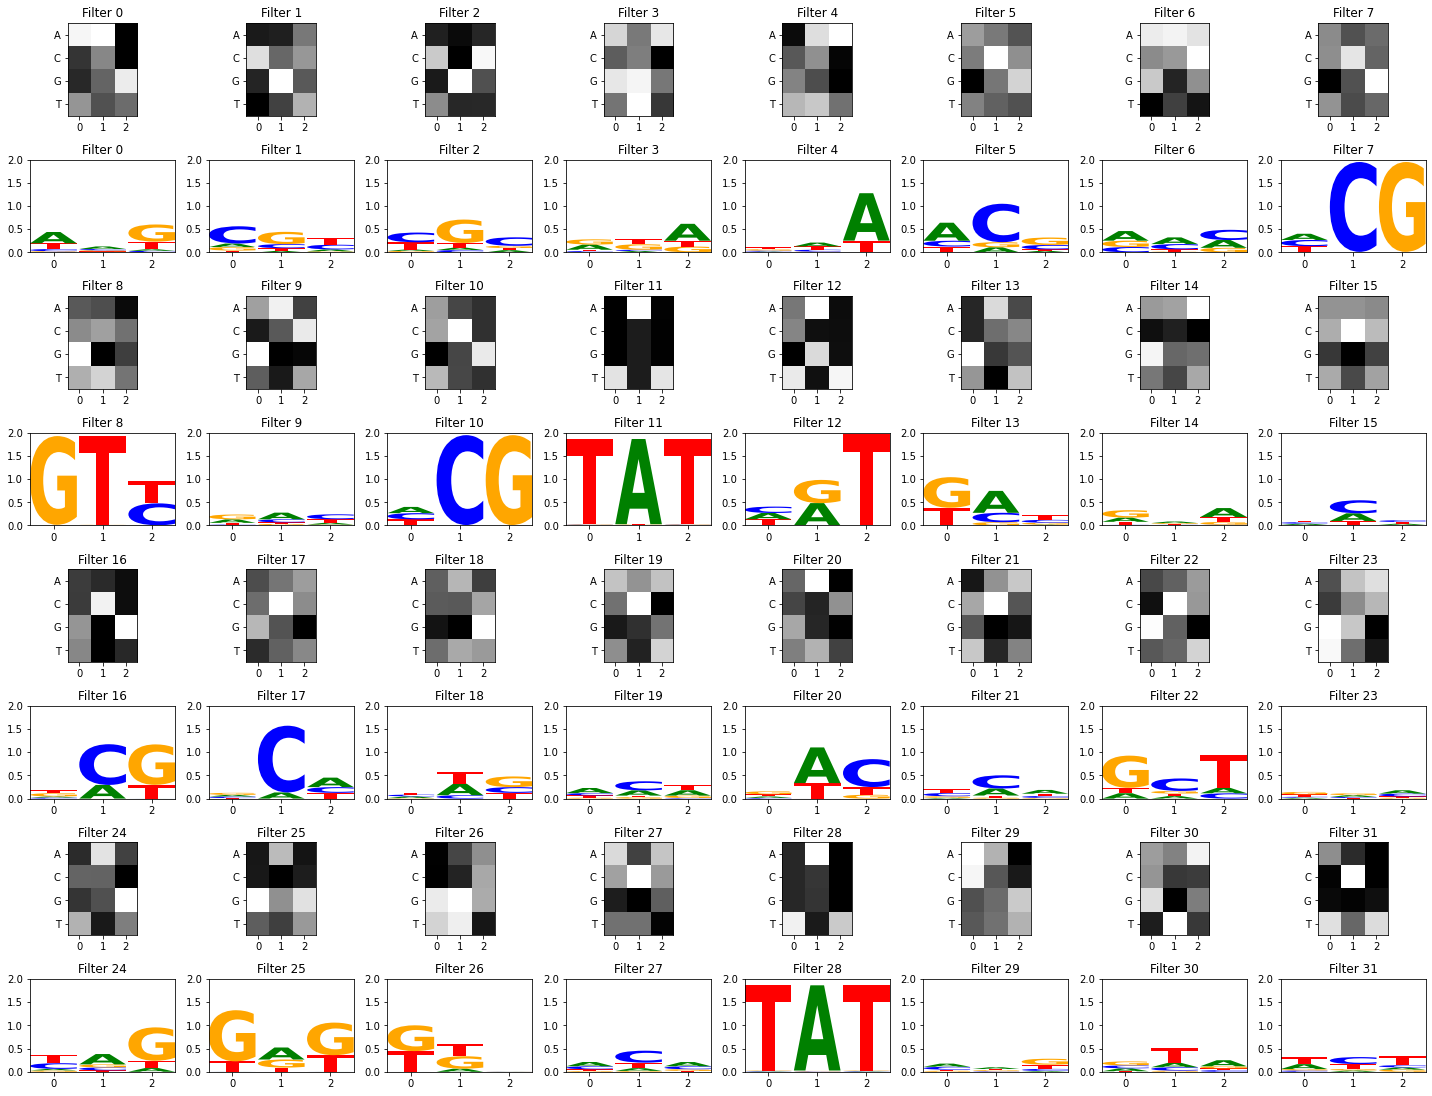

In [75]:
view_filters_and_logos(model_weights,filter_activations)

# 8mer model cnn

In [76]:
conv_layers, model_weights, bias_weights = get_conv_layers_from_model(mer8motif_model_cnn)

Total convolutional layers: 1


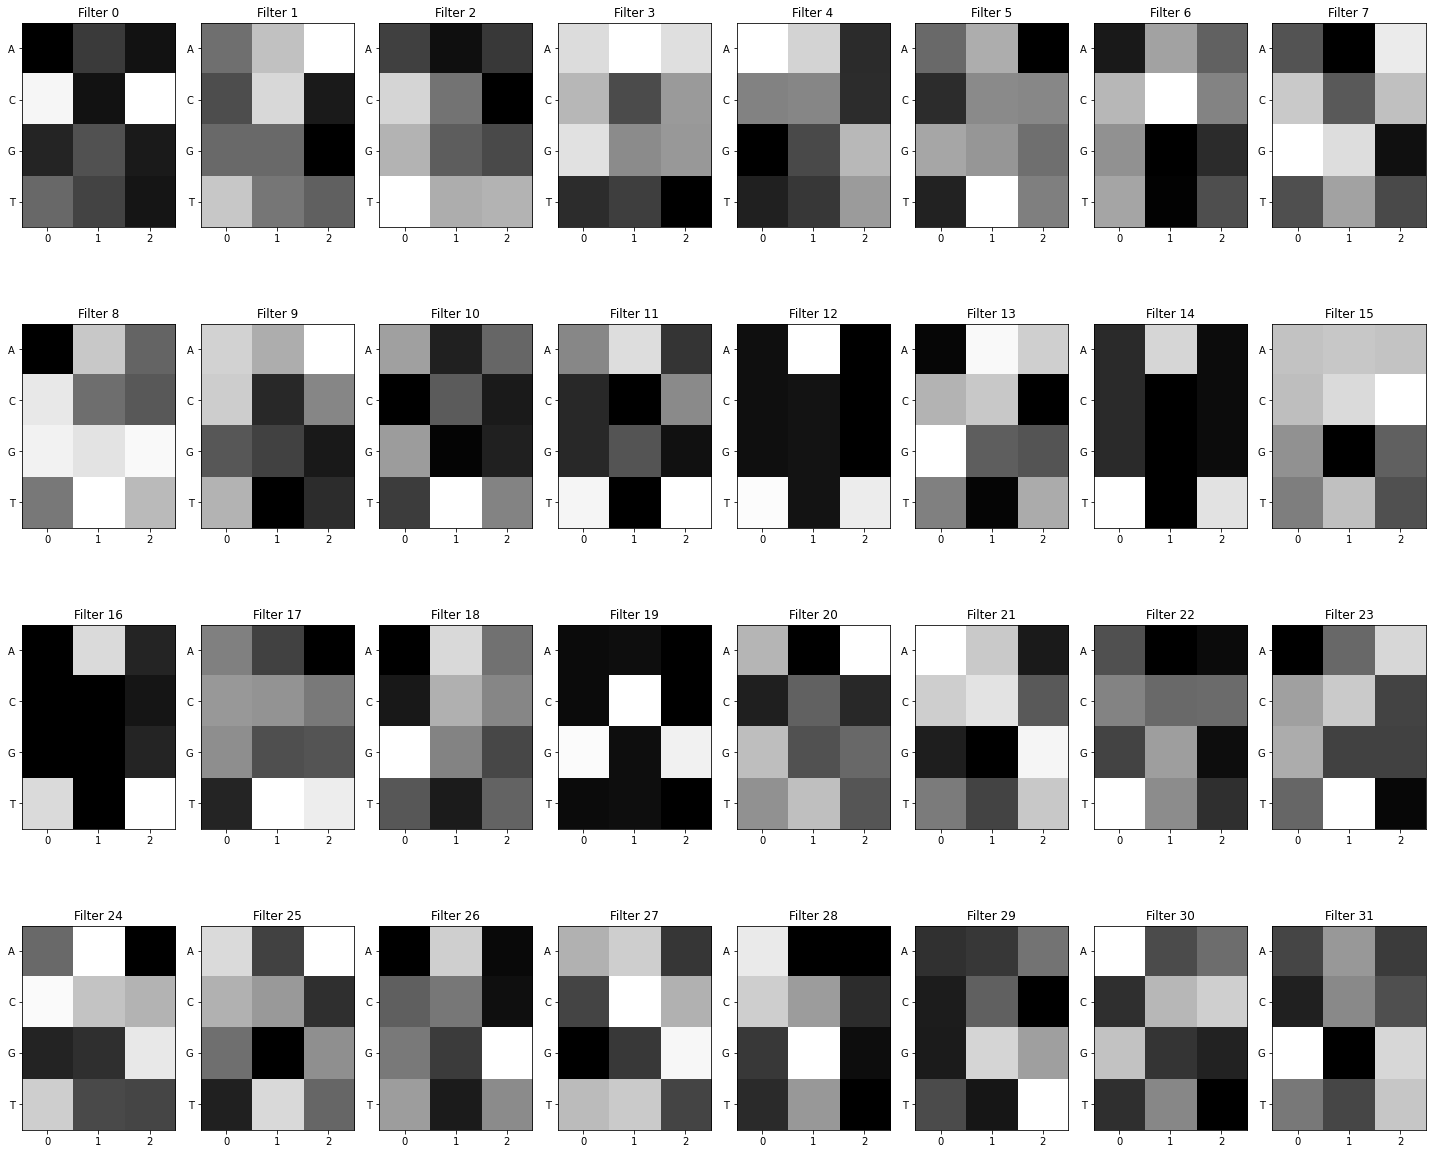

In [77]:
view_filters(model_weights)

In [78]:
train_seqs = list(mer6motif_train_df['seq'])
filter_activations = get_filter_activations(train_seqs, conv_layers[0])

Running seq AAAAAA
Running seq AAAAAG
Running seq AAAACC
Running seq AAAACG
Running seq AAAACT
Running seq AAAAGA
Running seq AAAAGC
Running seq AAAAGG
Running seq AAAATA
Running seq AAAATC
Running seq AAAATG
Running seq AAAATT
Running seq AAACAA
Running seq AAACAC
Running seq AAACAG
Running seq AAACAT
Running seq AAACCA
Running seq AAACCC
Running seq AAACCG
Running seq AAACCT
Running seq AAACGA
Running seq AAACGG
Running seq AAACTA
Running seq AAACTC
Running seq AAACTG
Running seq AAACTT
Running seq AAAGAA
Running seq AAAGAC
Running seq AAAGAG
Running seq AAAGAT
Running seq AAAGCA
Running seq AAAGCC
Running seq AAAGCT
Running seq AAAGGA
Running seq AAAGGC
Running seq AAAGGG
Running seq AAAGGT
Running seq AAAGTA
Running seq AAAGTC
Running seq AAAGTG
Running seq AAAGTT
Running seq AAATAA
Running seq AAATAG
Running seq AAATCA
Running seq AAATCC
Running seq AAATCG
Running seq AAATCT
Running seq AAATGA
Running seq AAATGG
Running seq AAATGT
Running seq AAATTA
Running seq AAATTC
Running seq 

Running seq AGCAAC
Running seq AGCAAG
Running seq AGCAAT
Running seq AGCACC
Running seq AGCACG
Running seq AGCACT
Running seq AGCAGA
Running seq AGCAGC
Running seq AGCATA
Running seq AGCATC
Running seq AGCATG
Running seq AGCATT
Running seq AGCCAA
Running seq AGCCAC
Running seq AGCCAG
Running seq AGCCCA
Running seq AGCCCC
Running seq AGCCCG
Running seq AGCCGA
Running seq AGCCGC
Running seq AGCCGG
Running seq AGCCGT
Running seq AGCCTA
Running seq AGCCTG
Running seq AGCCTT
Running seq AGCGAC
Running seq AGCGAG
Running seq AGCGAT
Running seq AGCGCA
Running seq AGCGCC
Running seq AGCGCG
Running seq AGCGCT
Running seq AGCGGA
Running seq AGCGGC
Running seq AGCGGT
Running seq AGCGTA
Running seq AGCGTC
Running seq AGCGTT
Running seq AGCTAA
Running seq AGCTAG
Running seq AGCTAT
Running seq AGCTCC
Running seq AGCTCT
Running seq AGCTGG
Running seq AGCTGT
Running seq AGCTTA
Running seq AGGAAA
Running seq AGGAAG
Running seq AGGAAT
Running seq AGGACA
Running seq AGGACC
Running seq AGGACG
Running seq 

Running seq CACTGC
Running seq CACTGG
Running seq CACTGT
Running seq CACTTA
Running seq CACTTC
Running seq CACTTG
Running seq CACTTT
Running seq CAGAAA
Running seq CAGACC
Running seq CAGACG
Running seq CAGACT
Running seq CAGAGA
Running seq CAGAGC
Running seq CAGAGG
Running seq CAGAGT
Running seq CAGATA
Running seq CAGATC
Running seq CAGATG
Running seq CAGATT
Running seq CAGCAA
Running seq CAGCAC
Running seq CAGCAT
Running seq CAGCCA
Running seq CAGCCC
Running seq CAGCCT
Running seq CAGCGA
Running seq CAGCGC
Running seq CAGCGT
Running seq CAGCTA
Running seq CAGCTC
Running seq CAGGAA
Running seq CAGGAT
Running seq CAGGCA
Running seq CAGGCC
Running seq CAGGCG
Running seq CAGGCT
Running seq CAGGGA
Running seq CAGGGG
Running seq CAGGTA
Running seq CAGGTC
Running seq CAGGTG
Running seq CAGTAA
Running seq CAGTAC
Running seq CAGTAG
Running seq CAGTAT
Running seq CAGTCA
Running seq CAGTCC
Running seq CAGTCG
Running seq CAGTCT
Running seq CAGTGA
Running seq CAGTGC
Running seq CAGTGG
Running seq 

Running seq CGGGTC
Running seq CGGGTG
Running seq CGGGTT
Running seq CGGTAA
Running seq CGGTAC
Running seq CGGTAT
Running seq CGGTCA
Running seq CGGTCC
Running seq CGGTCT
Running seq CGGTGA
Running seq CGGTGC
Running seq CGGTGG
Running seq CGGTGT
Running seq CGGTTA
Running seq CGGTTG
Running seq CGGTTT
Running seq CGTAAA
Running seq CGTAAC
Running seq CGTAAG
Running seq CGTAAT
Running seq CGTACC
Running seq CGTACG
Running seq CGTACT
Running seq CGTAGA
Running seq CGTAGC
Running seq CGTAGG
Running seq CGTAGT
Running seq CGTATC
Running seq CGTATT
Running seq CGTCAA
Running seq CGTCAC
Running seq CGTCAG
Running seq CGTCAT
Running seq CGTCCA
Running seq CGTCCC
Running seq CGTCCG
Running seq CGTCGC
Running seq CGTCGG
Running seq CGTCGT
Running seq CGTCTA
Running seq CGTCTC
Running seq CGTCTG
Running seq CGTCTT
Running seq CGTGAA
Running seq CGTGAG
Running seq CGTGCA
Running seq CGTGCC
Running seq CGTGCT
Running seq CGTGGA
Running seq CGTGGC
Running seq CGTGTA
Running seq CGTGTC
Running seq 

Running seq GATGTA
Running seq GATGTG
Running seq GATTAA
Running seq GATTAC
Running seq GATTAG
Running seq GATTAT
Running seq GATTCA
Running seq GATTCC
Running seq GATTCG
Running seq GATTCT
Running seq GATTGA
Running seq GATTGG
Running seq GATTGT
Running seq GATTTC
Running seq GATTTG
Running seq GATTTT
Running seq GCAAAA
Running seq GCAAAC
Running seq GCAAAG
Running seq GCAACA
Running seq GCAACC
Running seq GCAACG
Running seq GCAACT
Running seq GCAAGA
Running seq GCAAGC
Running seq GCAAGG
Running seq GCAAGT
Running seq GCAATA
Running seq GCAATC
Running seq GCAATT
Running seq GCACAG
Running seq GCACAT
Running seq GCACCA
Running seq GCACCC
Running seq GCACCT
Running seq GCACGA
Running seq GCACGC
Running seq GCACGG
Running seq GCACGT
Running seq GCACTC
Running seq GCACTG
Running seq GCACTT
Running seq GCAGAA
Running seq GCAGAC
Running seq GCAGAG
Running seq GCAGAT
Running seq GCAGCA
Running seq GCAGCC
Running seq GCAGCG
Running seq GCAGGA
Running seq GCAGGC
Running seq GCAGGG
Running seq 

Running seq GTACCG
Running seq GTACCT
Running seq GTACGC
Running seq GTACGG
Running seq GTACGT
Running seq GTACTA
Running seq GTACTG
Running seq GTACTT
Running seq GTAGAC
Running seq GTAGAG
Running seq GTAGCA
Running seq GTAGCC
Running seq GTAGCG
Running seq GTAGGA
Running seq GTAGGG
Running seq GTAGGT
Running seq GTAGTA
Running seq GTAGTC
Running seq GTAGTG
Running seq GTAGTT
Running seq GTATAC
Running seq GTATAG
Running seq GTATAT
Running seq GTATCA
Running seq GTATCC
Running seq GTATCT
Running seq GTATGC
Running seq GTATGG
Running seq GTATGT
Running seq GTATTA
Running seq GTATTC
Running seq GTATTG
Running seq GTATTT
Running seq GTCAAA
Running seq GTCAAG
Running seq GTCAAT
Running seq GTCACA
Running seq GTCACC
Running seq GTCAGA
Running seq GTCAGC
Running seq GTCAGG
Running seq GTCAGT
Running seq GTCATG
Running seq GTCATT
Running seq GTCCAA
Running seq GTCCAC
Running seq GTCCAG
Running seq GTCCAT
Running seq GTCCCA
Running seq GTCCCG
Running seq GTCCCT
Running seq GTCCGA
Running seq 

Running seq TCCAGT
Running seq TCCATA
Running seq TCCATC
Running seq TCCATG
Running seq TCCATT
Running seq TCCCAA
Running seq TCCCAG
Running seq TCCCAT
Running seq TCCCCG
Running seq TCCCGA
Running seq TCCCGC
Running seq TCCCGG
Running seq TCCCGT
Running seq TCCCTA
Running seq TCCCTG
Running seq TCCCTT
Running seq TCCGAA
Running seq TCCGAC
Running seq TCCGAT
Running seq TCCGCT
Running seq TCCGGG
Running seq TCCGGT
Running seq TCCGTC
Running seq TCCGTT
Running seq TCCTAA
Running seq TCCTAC
Running seq TCCTAG
Running seq TCCTCA
Running seq TCCTCG
Running seq TCCTCT
Running seq TCCTGA
Running seq TCCTGG
Running seq TCCTTC
Running seq TCCTTG
Running seq TCGAAA
Running seq TCGAAG
Running seq TCGACA
Running seq TCGACC
Running seq TCGACG
Running seq TCGACT
Running seq TCGAGA
Running seq TCGAGC
Running seq TCGAGG
Running seq TCGAGT
Running seq TCGATA
Running seq TCGATC
Running seq TCGATG
Running seq TCGCAA
Running seq TCGCAT
Running seq TCGCCC
Running seq TCGCCG
Running seq TCGCCT
Running seq 

Running seq TTCTGA
Running seq TTCTGC
Running seq TTCTGG
Running seq TTCTTA
Running seq TTCTTC
Running seq TTCTTG
Running seq TTCTTT
Running seq TTGAAC
Running seq TTGAAG
Running seq TTGAAT
Running seq TTGACC
Running seq TTGACG
Running seq TTGACT
Running seq TTGAGA
Running seq TTGAGC
Running seq TTGAGG
Running seq TTGAGT
Running seq TTGATC
Running seq TTGATT
Running seq TTGCAA
Running seq TTGCAC
Running seq TTGCAT
Running seq TTGCCA
Running seq TTGCCC
Running seq TTGCCG
Running seq TTGCCT
Running seq TTGCGA
Running seq TTGCGC
Running seq TTGCGG
Running seq TTGCGT
Running seq TTGCTC
Running seq TTGCTG
Running seq TTGGAA
Running seq TTGGAC
Running seq TTGGCA
Running seq TTGGCC
Running seq TTGGCG
Running seq TTGGCT
Running seq TTGGGA
Running seq TTGGGC
Running seq TTGGGG
Running seq TTGGTA
Running seq TTGGTC
Running seq TTGGTG
Running seq TTGGTT
Running seq TTGTAC
Running seq TTGTAT
Running seq TTGTCA
Running seq TTGTCC
Running seq TTGTCG
Running seq TTGTCT
Running seq TTGTGA
Running seq 

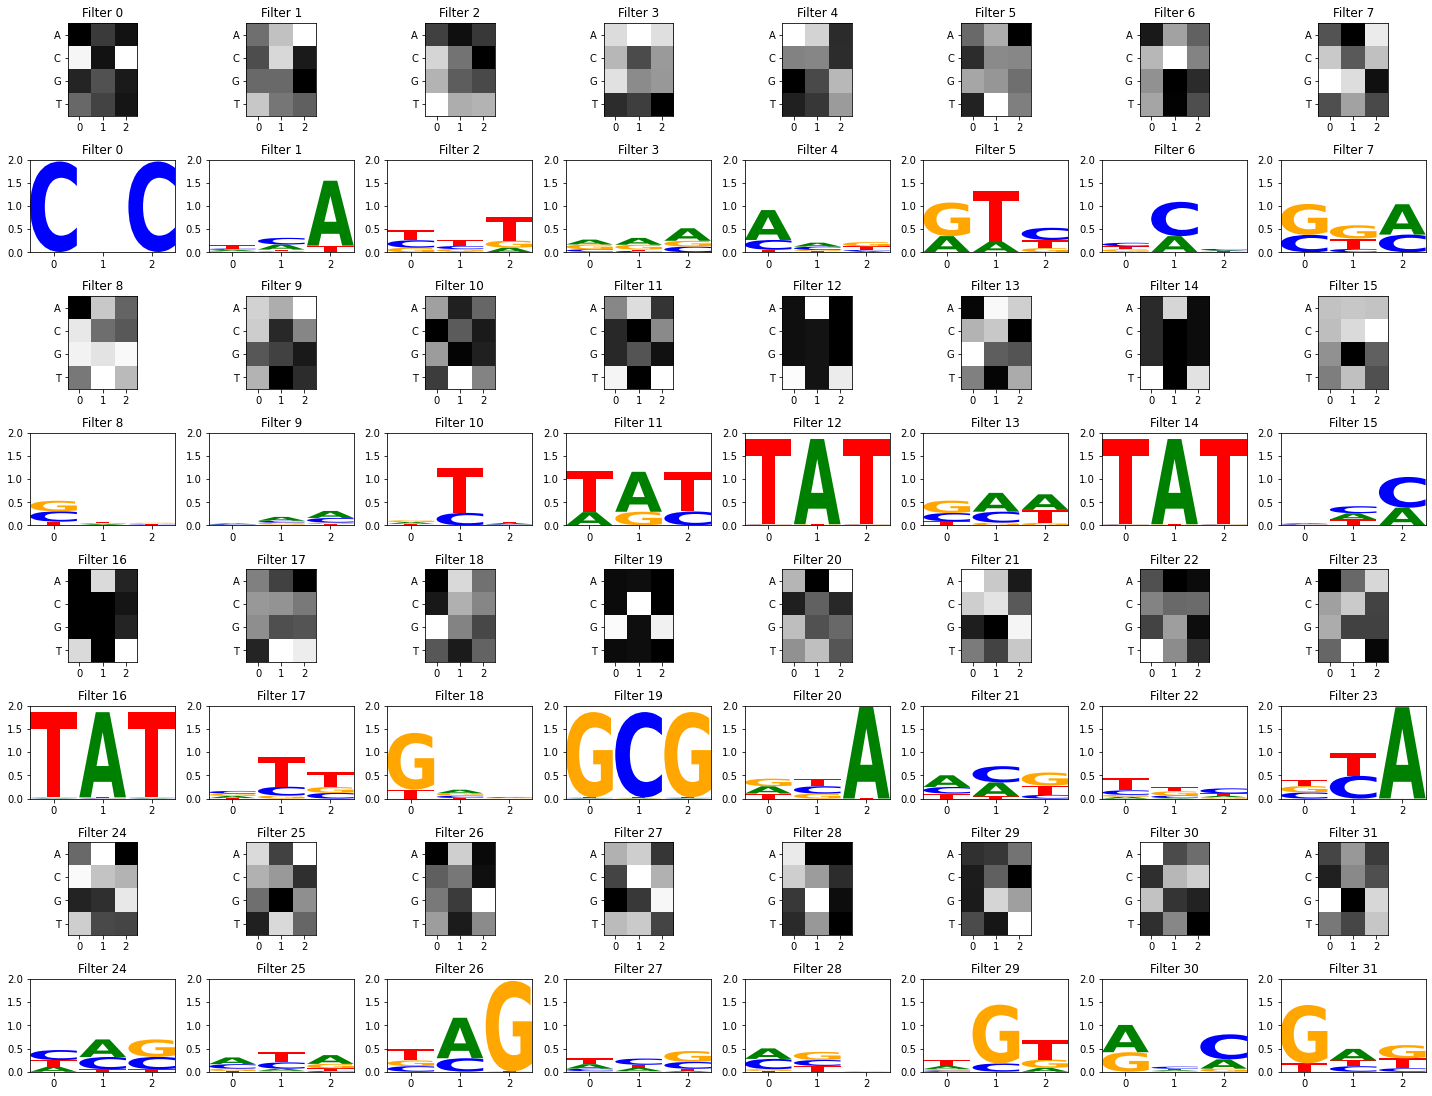

In [79]:
view_filters_and_logos(model_weights,filter_activations)